# Logistic growth model

In the following example we consider the logistic growth model that can be used to modelize the population growth:

$$\dot{y} = a y(t) - b y(t)^2 \hspace{5mm} \forall t \in [t_0, t_{max}] \hspace{5mm}$$

With:

- $a>0$ the growth rate
- $b>0$ limiting term
- $y(t)$ the population size
- $y_0 = y(t_0)$ the initial population
- $t_0$ the initial time
- $t_{max}$ the final time

R. Pearl and L. Reed (1920) determined the parameters to be $a=0.03134$ and $b=1.5887\times10^{-10}$ for the US population between 1790 and 1910.

We're going to use the same $a,b$ parameters with even more data until the year 2000.

We will study the influence of the $y_0$, $a$, $b$ parameters modelized by random variables:

- $y_0 \sim \mathcal{N}$
- $a \sim \mathcal{N}$
- $b \sim \mathcal{N}$


In [1]:
from __future__ import print_function
import openturns as ot
from numpy import linspace, exp, maximum

In [2]:
# Some data
ustime=list(range(1790,2001,10))
uspop=[3.9,5.3,7.2,9.6,13.,17.,23.,31.,39., 50.,62.,76.,92.,106.,123.,132.,151.,179., 203.,221.,250.,281.]

In [3]:
# Creation of the input distribution
y0 = 3.9e6
a = 0.03134
b = 1.5887e-10
distY0 = ot.Normal(y0, 0.1 * y0)
distA  = ot.Normal(a, 0.3 * a)
distB  = ot.Normal(b, 0.3 * b)
distX = ot.ComposedDistribution([distY0, distA, distB])

In [4]:
# The model
class Popu(ot.OpenTURNSPythonPointToFieldFunction):

    def __init__(self, t0 = 1790.0, tfinal = 2000.0, nt = 1000):
        grid = ot.RegularGrid(t0, (tfinal - t0) / (nt - 1), nt)
        super(Popu, self).__init__(3, grid, 1)
        self.setInputDescription(['y0', 'a', 'b'])
        self.setOutputDescription(['N'])
        self.ticks_ = [t[0] for t in grid.getVertices()]
        self.phi_ = ot.SymbolicFunction(['t', 'y', 'a', 'b'], ['a*y - b*y^2'])
        
    def _exec(self, X):
        y0 = X[0]
        a  = X[1]
        b  = X[2]
        phi_ab = ot.ParametricFunction(self.phi_, [2, 3], [a, b])
        phi_t = ot.ParametricFunction(phi_ab, [0], [0.0])
        solver = ot.RungeKutta(phi_t)
        initialState = [y0]
        values = solver.solve(initialState, self.ticks_)
        return values * [1.0e-6]

F = Popu(1790.0, 2000.0, 1000)
popu = ot.PointToFieldFunction(F)

In [5]:
# Sample the model
size = 10
inputSample = distX.getSample(size)
outputSample = popu(inputSample)

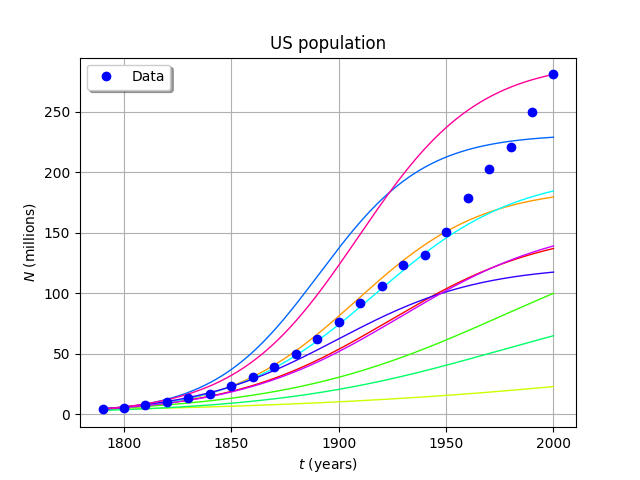

In [6]:
# Draw some curves
graph = outputSample.drawMarginal(0)
graph.setTitle('US population')
graph.setXTitle(r'$t$ (years)')
graph.setYTitle(r'$N$ (millions)')
graph.setColors([ot.Drawable.ConvertFromHSV(i * (360.0/size), 1.0, 1.0) for i in range(len(graph.getDrawables()))])
cloud = ot.Cloud(ustime, uspop)
cloud.setPointStyle('circle')
cloud.setLegend('Data')
graph.add(cloud)
graph.setLegendPosition('topleft')
graph
